In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Conv2D, Conv1D, MaxPooling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow import keras, config
import numpy as np
import matplotlib.pyplot as plt

In [15]:
print("GPUs Available: ", len(config.list_physical_devices('GPU')))

GPUs Available:  1


In [16]:
from image_process.image_preprocessors import add_noise,add_noise_randomly, shift_random_update_positions
from data_filters import min_n_letters, take_percent
# Global settings
TEST_SPLIT_SIZE = 0.80
VALIDATION_SPLIT_SIZE = 0.90
IMAGE_TARGET_SIZE = (5, 1400, 1)
BATCH_SIZE =  128
LETTER_END_POSITION = "P1"
ADD_NOISE_RANDOMLY = [0, 15]
IMAGE_PREPOCESSORS = [
    {"func": add_noise_randomly, "params" : ADD_NOISE_RANDOMLY}
]
MASKS = [
    {"func": min_n_letters, "params" : 3}, 
    {"func": take_percent, "params": 100}
]

In [17]:

%load_ext autoreload
%autoreload 2

from morse_helpers import create_sets
from morse_label_funcs import velocity_regression_v2

def get_sets():
    return [
        ["./training_data/MorseTrainSet_18/GEN18_VER_012/", 'wordsMatrices_18_012', "Words_18_012.csv"],
        ["./training_data/MorseTrainSet_18/GEN18_VER_021/", 'wordsMatrices_18_021', "Words_18_021.csv"],
        ["./training_data/MorseTrainSet_18/GEN18_VER_022/", 'wordsMatrices_18_022', "Words_18_022.csv"],
        ["./training_data/MorseTrainSet_18/GEN18_VER_111/", 'wordsMatrices_18_111', "Words_18_111.csv"],
        ["./training_data/MorseTrainSet_18/GEN18_VER_222/", 'wordsMatrices_18_222', "Words_18_222.csv"],
        ["./training_data/MorseTrainSet_18/GEN18_VER_301/", 'wordsMatrices_18_301', "Words_18_301.csv"],
        ["./training_data/MorseTrainSet_18/GEN18_VER_320/", 'wordsMatrices_18_320', "Words_18_320.csv"],
        ["./training_data/MorseTrainSet_18/GEN18_VER_411/", 'wordsMatrices_18_411', "Words_18_411.csv"],
        ["./training_data/MorseTrainSet_18/GEN18_VER_410/", 'wordsMatrices_18_410', "Words_18_410.csv"],
        ["./training_data/MorseTrainSet_18/GEN18_VER_402/", 'wordsMatrices_18_402', "Words_18_402.csv"],
    ]

(image_fnames, morse_labels) = create_sets(
    get_sets(), 
    IMAGE_TARGET_SIZE,
    [velocity_regression_v2],
    letter_n=LETTER_END_POSITION,
    overwrite_images=False,
    masks=MASKS
)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
morse_labels = np.array(morse_labels[0])

In [19]:
morse_labels.shape

(259935,)

In [20]:
from morse_helpers import create_all_sets

train, labels, train_validation, labels_validation, train_test, labels_test = create_all_sets(
    image_fnames, morse_labels, TEST_SPLIT_SIZE, VALIDATION_SPLIT_SIZE, shuffle_before_test_split=True)

In [21]:
from keras_generators.image_generator import Image_Generator
from morse_helpers import return_label_positions

training_batch_generator = Image_Generator(train, labels, BATCH_SIZE, IMAGE_TARGET_SIZE, IMAGE_PREPOCESSORS, return_label_positions)
validation_batch_generator = Image_Generator(train_validation, labels_validation, BATCH_SIZE, IMAGE_TARGET_SIZE, IMAGE_PREPOCESSORS, return_label_positions)

In [22]:
(t, l) = training_batch_generator.__getitem__(0)

l

array([0.19003801, 0.15176042, 0.20624632, 0.19719976, 0.14467593,
       0.38      , 0.32      , 0.21      , 0.31695721, 0.21923269,
       0.22237946, 0.23027633, 0.25311329, 0.16993203, 0.17903322,
       0.30024019, 0.33652866, 0.26      , 0.21075873, 0.16      ,
       0.21023125, 0.1497006 , 0.23959269, 0.30950479, 0.16114412,
       0.17071701, 0.29      , 0.20381127, 0.31      , 0.27      ,
       0.17185605, 0.38041846, 0.22      , 0.29      , 0.19020923,
       0.3       , 0.25007502, 0.23120225, 0.16      , 0.18650917,
       0.29568303, 0.18191006, 0.23845007, 0.25575448, 0.36579338,
       0.30153784, 0.23738872, 0.28845163, 0.19068647, 0.32      ,
       0.33908447, 0.17958695, 0.16222245, 0.36378335, 0.16      ,
       0.3061426 , 0.27097551, 0.36651808, 0.20926756, 0.2       ,
       0.25504999, 0.16153458, 0.16082018, 0.22485691, 0.1781649 ,
       0.18093515, 0.33467861, 0.24      , 0.2122284 , 0.23868722,
       0.24266936, 0.20012007, 0.25057633, 0.23      , 0.26015

In [23]:
def conv_model_velocity(input_layer):
    x = keras.layers.Cropping2D(cropping=((0, 0), (0,200)), data_format=None)(input_layer)

    x = Conv2D(90,(1,7), padding="same",activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,1),padding="same")(x)

    x = Conv2D(90,(1,7),padding="same",activation="relu")(x)
    x = MaxPooling2D(pool_size=(1,2),padding="same")(x)

    x = Conv2D(90,(1,5),padding="same",activation="relu")(x)
    x = MaxPooling2D(pool_size=(1,2),padding="same")(x)

    x = Conv2D(90,(3,3),padding="same",activation="relu")(x)
    x = MaxPooling2D(pool_size=(1,2),padding="same")(x)

    x = Conv2D(90,(3,3),padding="same",activation="relu")(x)
    x = MaxPooling2D(pool_size=(1,2),padding="same")(x)

    x = Conv2D(90,(3,3),padding="same",activation="relu")(x)
    x = MaxPooling2D(pool_size=(1,2),padding="same")(x)

    x = Conv2D(90,(3,3),padding="same",activation="relu")(x)
    x = MaxPooling2D(pool_size=(1,2),padding="same")(x)

    x = Flatten()(x)

    return x

In [24]:
from tensorflow.keras import layers

input_layer    = Input(shape=IMAGE_TARGET_SIZE)
conv_model_position_flattened = conv_model_velocity(input_layer)
output_layer_position    = Dense(1, name="regr")(conv_model_position_flattened)

model           = Model(inputs=input_layer, outputs=output_layer_position)
model.compile(loss=["mse"], optimizer='adam', metrics=["mean_absolute_error"])

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 1400, 1)]      0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 5, 1200, 1)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 1200, 90)       720       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 1200, 90)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 1200, 90)       56790     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 600, 90)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 600, 90)        4059

In [25]:
init_epoch = 0

In [26]:

num_epochs = 5

def fit_model(epochs):
	
	global init_epoch
	history = model.fit(
		training_batch_generator,
		steps_per_epoch = int(len(train) // BATCH_SIZE),
		epochs = epochs + init_epoch,
		initial_epoch=init_epoch,
		verbose =1,
		validation_data = validation_batch_generator,
		validation_steps = int(len(train_validation) // BATCH_SIZE),
		workers=2,
		use_multiprocessing=True
	)
					
	init_epoch += epochs
	return history

history = fit_model(num_epochs)


Epoch 1/5
1461/1461 [==============================] - 155s 106ms/step - loss: 8.0878e-04 - mean_absolute_error: 0.0125 - val_loss: 3.3046e-05 - val_mean_absolute_error: 0.0043
Epoch 2/5
1461/1461 [==============================] - 152s 104ms/step - loss: 2.6241e-05 - mean_absolute_error: 0.0037 - val_loss: 1.4079e-05 - val_mean_absolute_error: 0.0028
Epoch 3/5
1461/1461 [==============================] - 154s 105ms/step - loss: 1.8208e-05 - mean_absolute_error: 0.0030 - val_loss: 9.7486e-06 - val_mean_absolute_error: 0.0024
Epoch 4/5
1461/1461 [==============================] - 168s 115ms/step - loss: 1.1289e-05 - mean_absolute_error: 0.0025 - val_loss: 1.4751e-05 - val_mean_absolute_error: 0.0028
Epoch 5/5
1461/1461 [==============================] - 149s 102ms/step - loss: 3.1093e-05 - mean_absolute_error: 0.0031 - val_loss: 9.9145e-06 - val_mean_absolute_error: 0.0021


In [27]:
def show_image(img):
    plt.figure(figsize=(30,5))
    plt.xlim(0, 300)
    plt.imshow(img)
    plt.show()

In [28]:
tempo_diff_above = 1

def get_deviating_predictions(tempo_diff_above, generator, predictions):
    regression_differences = []
    indexer = 0

    for imgs_batch, labels_batch in generator:

        for i in range(len(imgs_batch)):

            regr_pred = predictions[indexer] * 100
            regr_test_label = labels_batch[i] * 100

            if abs(regr_pred[0] - regr_test_label) > tempo_diff_above:
                regression_differences.append([regr_pred, regr_test_label, imgs_batch[i]])

            indexer += 1

    return regression_differences

In [29]:
%%capture cap --no-stderr
from training_log import Training_Data_Log, print_name, json_to_file
import inspect

data_log = Training_Data_Log()
data_log.model_config = model.to_json()
data_log.model_config_method_string = [inspect.getsource(conv_model_velocity)]
data_log.training_sets = get_sets()
data_log.training_set_size = len(train)
data_log.validation_set_size = len(train_validation)
data_log.test_set_size = len(train_test)
data_log.image_pre_processors = print_name(IMAGE_PREPOCESSORS)
data_log.noise_added = ADD_NOISE_RANDOMLY
data_log.training_data_masks = print_name(MASKS)
data_log.model_summary = model.summary()
data_log.model_optimizer = str(type(model.optimizer))
data_log.model_history = history.history
data_log.model_history_final_epoch = {k: v[-1] for k, v in history.history.items()}
data_log.total_epochs = init_epoch


In [30]:
class Velocity_Results:
    total_predictions = None
    noise_level = None
    difference = None
    image_preprocessors_test = None
    predictions_off_by_more_than_difference = None
    predictions_incorrect_prercent = None
    model_evaluation = None

noise_levels = [0.0, 0.1]
result_array = []
for noise_level in noise_levels:

    image_preprocessors_test = [{"func": add_noise, "params" : noise_level}]
    test_batch_generator = Image_Generator(train_test, labels_test, BATCH_SIZE, IMAGE_TARGET_SIZE, image_preprocessors_test, return_label_positions)
    predictions = model.predict(test_batch_generator)
    velocity_differences  = get_deviating_predictions(tempo_diff_above, test_batch_generator, predictions)
    evaluations = model.evaluate(test_batch_generator, verbose = 0)

    results = Velocity_Results()
    results.total_predictions = len(predictions)
    results.noise_level = noise_level
    results.difference = tempo_diff_above
    results.image_preprocessors_test = print_name(image_preprocessors_test)
    results.predictions_off_by_more_than_difference = len(velocity_differences)
    results.predictions_incorrect_prercent = round( (len(velocity_differences) / len(predictions) * 100), 4)
    results.model_evaluation = evaluations

    result_array.append(results.__dict__)


In [31]:
data_log.results = result_array

In [32]:
json_to_file("logs/velocity/velocity_data_log", data_log)

Prediction 38
Correct 39


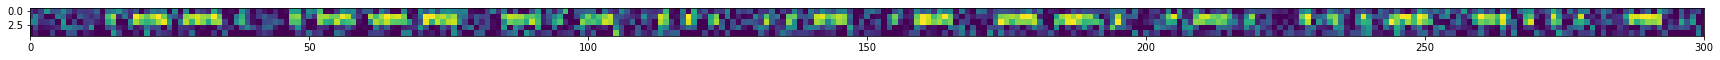

----------------------------------------------------------------------------------------
Prediction 36
Correct 39


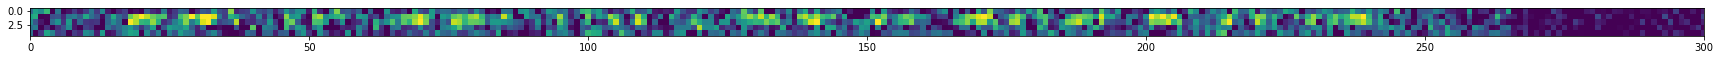

----------------------------------------------------------------------------------------
Prediction 31
Correct 32


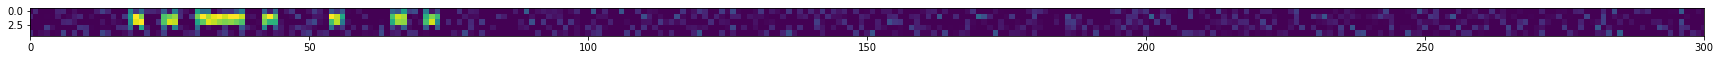

----------------------------------------------------------------------------------------
Prediction 31
Correct 32


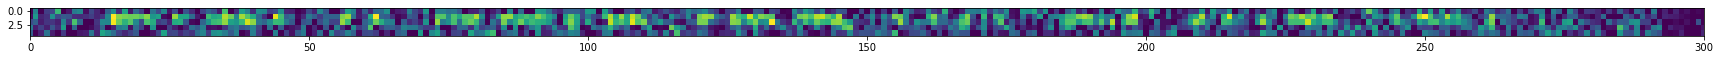

----------------------------------------------------------------------------------------
Prediction 38
Correct 39


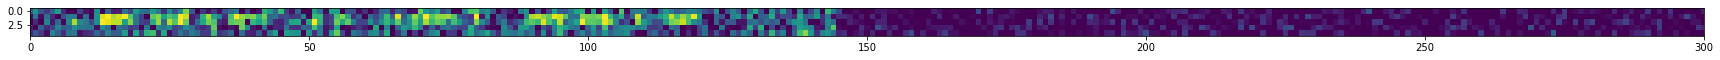

----------------------------------------------------------------------------------------
Prediction 28
Correct 30


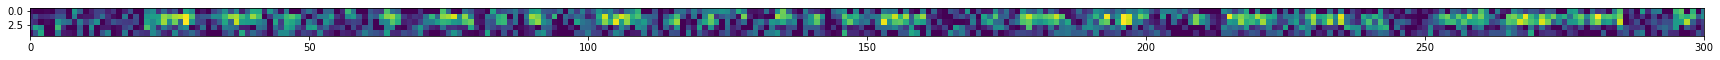

----------------------------------------------------------------------------------------
Prediction 37
Correct 38


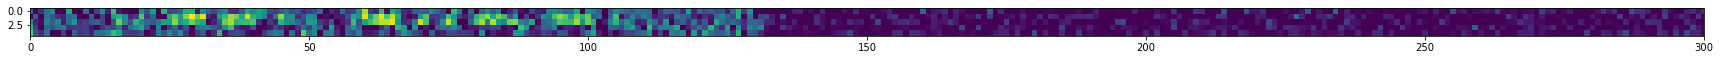

----------------------------------------------------------------------------------------
Prediction 23
Correct 25


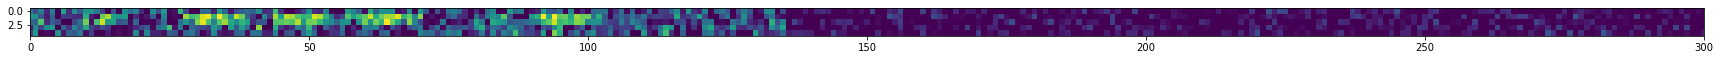

----------------------------------------------------------------------------------------
Prediction 37
Correct 38


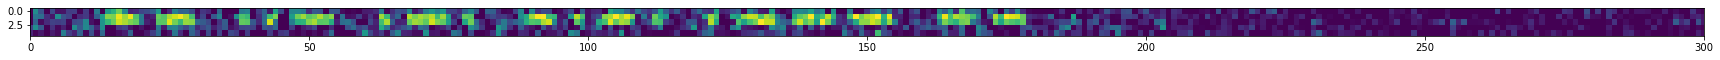

----------------------------------------------------------------------------------------
Prediction 36
Correct 37


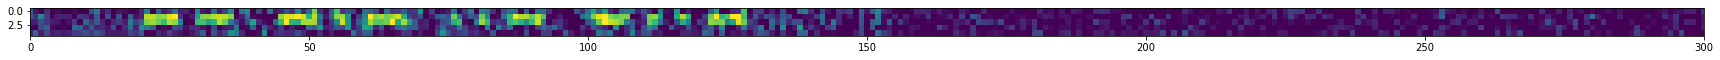

----------------------------------------------------------------------------------------
Prediction 34
Correct 35


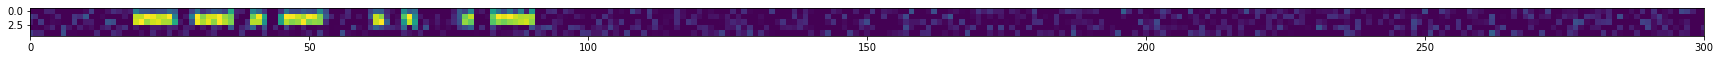

----------------------------------------------------------------------------------------


: 

In [33]:
for idx, diff in enumerate(velocity_differences):

    if idx > 10:
        break

    pred, correct, img = diff

    print('Prediction', round(pred[0]))
    print('Correct', round(correct))
    show_image(img)

    print("----------------------------------------------------------------------------------------")
